# First model: a single hidden layer

In [330]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
from datetime import datetime
import os
import sys
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from nolearn.lasagne import BatchIterator
import tensorflow as tf

## Loading data

Paths to datasets.

In [280]:
FTRAIN = '~/ML/kaggle/facial-keypoints-detection/data/training.csv'
FTEST = '~/ML/kaggle/facial-keypoints-detection/data/test.csv'
FLOOKUP = '~/ML/kaggle/facial-keypoints-detection/data/IdLookupTable.csv'

In [281]:
def load(test = False, cols = None):
#     Loads data from FTEST if *test* is True, otherwise from FTRAIN.
#     Pass a list of *cols* if you're only interested in a subset of the
#     target columns.
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

Load the training dataset.

In [282]:
X, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

Verify that data is ok by querying and plotting an arbitrary image.

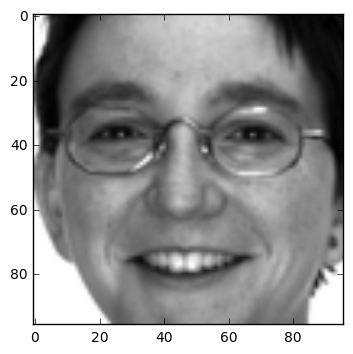

In [5]:
img = X[11].reshape(96, 96)
pyplot.imshow(img, cmap='gray')
pyplot.show()

Split the initial training dataset into training, validation and testing datasets.

In [283]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

## Parameters

In [323]:
# Predefined parameters
image_size = 96
num_keypoints = 30
batch_size = 36
num_epochs = 401
learning_rate = 0.01
momentum = 0.9

model_name = "single_hidden_layer_model"
model_variable_scope = model_name
model_path = "/tmp/" + model_name + "/model.ckpt"
summaries_dir = "/tmp/" + model_name + "/summaries/"

if tf.gfile.Exists(summaries_dir):
    tf.gfile.DeleteRecursively(summaries_dir)

## Routines

Performs a single fully connected layer pass, e.g. returns `input * weights + bias`:

In [285]:
def fully_connected(input, size):
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

Performs entire model pass, e.g. returns model prediction for given input with current model (single hidden fully connected layer):

In [286]:
def model_pass(input):
    with tf.variable_scope('hidden'):
        hidden = fully_connected(input, size = 100)
    relu_hidden = tf.nn.relu(hidden)
    with tf.variable_scope('out'):
        prediction = fully_connected(relu_hidden, size = num_keypoints)
    return prediction

Calculates loss based on model predictions.

In [287]:
def calc_loss(predictions, labels):
    return np.mean(np.square(predictions - labels))

Calculates time since `start` and formats as a string.

In [289]:
def get_time_hhmmss(start):
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## Training

In [290]:
graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size * image_size))
    tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))

    # Training computation.
    with tf.variable_scope(model_variable_scope):
        predictions = model_pass(tf_x_batch)
    
    loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))

    # Optimizer.
    optimizer = tf.train.MomentumOptimizer(
        learning_rate = learning_rate, 
        momentum = momentum, 
        use_nesterov = True
    ).minimize(loss)

In [293]:
def get_predictions_in_batches(X, y, session):
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, y_batch in batch_iterator(X, y):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch, 
                tf_y_batch : y_batch
            }
        )
        p.extend(p_batch)
    return p

In [324]:
start = time.time()
every_epoch_to_log = 5

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    train_loss_history = np.zeros(num_epochs)
    valid_loss_history = np.zeros(num_epochs)
    print("============ TRAINING =============")
    for epoch in range(num_epochs):
        # Train on whole randomised dataset in batches
        batch_iterator = BatchIterator(batch_size = batch_size, shuffle = True)
        accumulated_train_loss = 0
        for x_batch, y_batch in batch_iterator(x_train, y_train):
            session.run([optimizer], feed_dict = {
                    tf_x_batch : x_batch, 
                    tf_y_batch : y_batch
                }
            )

        # If another significant epoch ended, we log our losses.
        if (epoch % every_epoch_to_log == 0):
            # Get training data predictions and log training loss:
            train_loss = calc_loss(
                get_predictions_in_batches(x_train, y_train, session), 
                y_train
            )
            train_loss_history[epoch] = train_loss

            # Get validation data predictions and log validation loss:
            valid_loss = calc_loss(
                get_predictions_in_batches(x_valid, y_valid, session), 
                y_valid
            )
            valid_loss_history[epoch] = valid_loss

            logged_values_so_far += 1
            
            if (epoch % 100 == 0):
                print("--------- EPOCH %4d/%d ---------" % (epoch, num_epochs))
                print("     Train loss: %.8f" % (train_loss))
                print("Validation loss: %.8f" % (valid_loss))
                print("           Time: " + get_time_hhmmss(start))

    # Evaluate on test dataset.
    p_test = get_predictions_in_batches(x_test, y_test, session)
    test_loss = calc_loss(p_test, y_test)
    print("===================================")
    print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
    print(" Total time: " + get_time_hhmmss(start))
    
    # Save model weights for future use.
    save_path = saver.save(session, model_path)
    print("Model file: " + save_path)

============ TRAINING =============
--------- EPOCH    0/401 ---------
     Train loss: 0.01325483
Validation loss: 0.01231955
           Time: 00:00:02
--------- EPOCH  100/401 ---------
     Train loss: 0.00278652
Validation loss: 0.00388537
           Time: 00:00:25
--------- EPOCH  200/401 ---------
     Train loss: 0.00191002
Validation loss: 0.00320989
           Time: 00:00:49
--------- EPOCH  300/401 ---------
     Train loss: 0.00154163
Validation loss: 0.00297485
           Time: 00:01:14
--------- EPOCH  400/401 ---------
     Train loss: 0.00136017
Validation loss: 0.00295209
           Time: 00:01:38
 Test score: 2.557 (loss = 0.00283758)
 Total time: 00:01:38
Model file: /tmp/single_hidden_layer_model/model.ckpt


## Evaluation

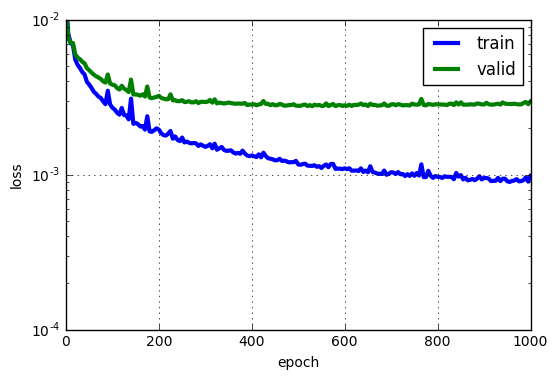

In [322]:
x_axis = np.arange(num_epochs)
train_loss_nonzero = train_loss_history > 0
valid_loss_nonzero = valid_loss_history > 0

pyplot.plot(x_axis[train_loss_nonzero], train_loss_history[train_loss_nonzero], linewidth=3, label="train")
pyplot.plot(x_axis[valid_loss_nonzero], valid_loss_history[valid_loss_nonzero], linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.001, 0.01)
pyplot.xlim(0, num_epochs)
pyplot.yscale("log")
pyplot.show()

Now, let's take a look at the data and predictions. 

Load training data, restore saved model parameters and get predictions:

In [136]:
X, _ = load(test = True)

with graph.as_default():
    tf_x = tf.constant(X)

    with tf.variable_scope(model_variable_scope, reuse = True):
        tf_p = model_pass(tf_x)  
        
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    load_path = saver.restore(session, model_path)
    p = tf_p.eval()

ImageId    1783
Image      1783
dtype: int64


Display some of the dataset images and our model's predictions:

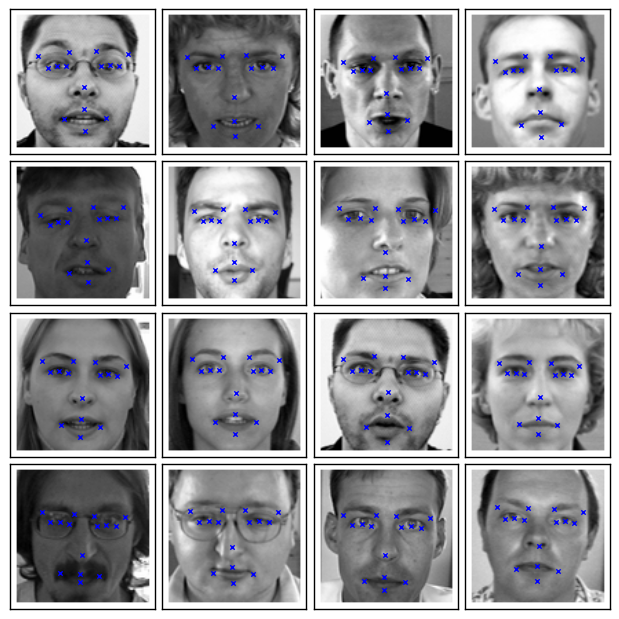

In [138]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], p[i], ax)

pyplot.show()